In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [116]:
csdf = pd.read_csv('cs.csv')
rainbowdf = pd.read_csv('rainbow6.csv')
data = yf.download('UBI.PA', start='2015-12-01', end='2026-02-01')

csdf['DateTime'] = pd.to_datetime(csdf['DateTime'], errors='coerce')
rainbowdf['DateTime'] = pd.to_datetime(rainbowdf['DateTime'], errors='coerce')

csdf = csdf.dropna(subset=['DateTime'])
rainbowdf = rainbowdf.dropna(subset=['DateTime'])

csdf = csdf[csdf['DateTime'] > '2015-12-01']
rainbowdf = rainbowdf[rainbowdf['DateTime'] > '2015-12-01']

csdf = csdf.sort_values('DateTime').set_index('DateTime')
rainbowdf = rainbowdf.sort_values('DateTime').set_index('DateTime')

csdf = csdf.asfreq('D')
rainbowdf = rainbowdf.asfreq('D')

stat_df = csdf.join(
    rainbowdf,
    how='outer',
    lsuffix='_cs',
    rsuffix='_r6'
)

#
# CS GO
#

# rolling means and stds
stat_df['cs_7d_mean'] = stat_df['Players_cs'].rolling(7).mean()
stat_df['cs_7d_std']  = stat_df['Players_cs'].rolling(7).std()

stat_df['cs_30d_mean'] = stat_df['Players_cs'].rolling(30).mean()
stat_df['cs_30d_std']  = stat_df['Players_cs'].rolling(30).std()

# vs 30d mean and momentum
stat_df['cs_vs_30d'] = (
    stat_df['Players_cs'] / stat_df['cs_30d_mean'] - 1
)

stat_df['cs_momentum'] = (
    stat_df['cs_7d_mean'] - stat_df['cs_30d_mean']
)

stat_df['cs_volatility_30d'] = (
    stat_df['cs_30d_std'] / stat_df['cs_30d_mean']
)

#
# R6
#

stat_df['r6_7d_mean'] = stat_df['Players_r6'].rolling(7).mean()
stat_df['r6_7d_std']  = stat_df['Players_r6'].rolling(7).std()

stat_df['r6_30d_mean'] = stat_df['Players_r6'].rolling(30).mean()
stat_df['r6_30d_std']  = stat_df['Players_r6'].rolling(30).std()

stat_df['r6_vs_30d'] = (
    stat_df['Players_r6'] / stat_df['r6_30d_mean'] - 1
)

stat_df['r6_momentum'] = (
    stat_df['r6_7d_mean'] - stat_df['r6_30d_mean']
)

stat_df['r6_volatility_30d'] = (
    stat_df['r6_30d_std'] / stat_df['r6_30d_mean']
)

# Time features

stat_df['dow'] = stat_df.index.dayofweek
stat_df['month'] = stat_df.index.month
stat_df['week_of_year'] = stat_df.index.isocalendar().week.astype(int)

stat_df = stat_df[stat_df.index >= '2016-02-01']
stat_df.drop(columns=['Average Players_cs', 'Average Players_r6'], inplace=True)

# Log transforms and lags

stat_df['cs_log'] = np.log1p(stat_df['Players_cs'])
stat_df['r6_log'] = np.log1p(stat_df['Players_r6'])

stat_df['cs_players_lag1'] = stat_df['Players_cs'].shift(1)
stat_df['r6_players_lag1'] = stat_df['Players_r6'].shift(1)

stat_df['cs_players_lag2'] = stat_df['Players_cs'].shift(2)
stat_df['r6_players_lag2'] = stat_df['Players_r6'].shift(2)


# Stock features

stock_df = data.copy()

stock_df.columns = stock_df.columns.get_level_values(0)

stock_df.index = pd.to_datetime(stock_df.index)

stock_df['stock_ret_1d'] = stock_df['Close'].pct_change()
stock_df['stock_ret_5d'] = stock_df['Close'].pct_change(5)

stock_df['stock_ret_lag1'] = stock_df['stock_ret_1d'].shift(1)
stock_df['stock_ret_lag2'] = stock_df['stock_ret_1d'].shift(2)

stock_df['stock_ma_5']  = stock_df['Close'].rolling(5).mean()
stock_df['stock_ma_30'] = stock_df['Close'].rolling(30).mean()

stock_df['stock_momentum'] = stock_df['stock_ma_5'] - stock_df['stock_ma_30']

stock_df['stock_vol_30d'] = stock_df['stock_ret_1d'].rolling(30).std()

stock_df = stock_df.reindex(stat_df.index, method='ffill')

stock_df = stock_df[stock_df.index >= '2016-02-01']

print(stock_df.head())

# Combine so that each row has a new stock price
stat_df = stat_df.join(
    stock_df[
        [
            'Close',
            'stock_ret_1d',
            'stock_ret_5d',
            'stock_ret_lag1',
            'stock_ret_lag2',
            'stock_ma_5',
            'stock_ma_30',
            'stock_momentum',
            'stock_vol_30d'
        ]
    ],
    how='right'
)

print(stat_df)

[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open  Volume  stock_ret_1d  \
DateTime                                                                       
2016-02-01  25.330000  25.420000  25.000000  25.350000  204049     -0.000592   
2016-02-02  25.129999  25.559999  25.010000  25.350000  231137     -0.007896   
2016-02-03  24.535000  25.270000  24.415001  25.080000  245297     -0.023677   
2016-02-04  23.990000  24.695000  23.700001  24.674999  342315     -0.022213   
2016-02-05  23.120001  24.070000  23.105000  24.010000  397232     -0.036265   

Price       stock_ret_5d  stock_ret_lag1  stock_ret_lag2  stock_ma_5  \
DateTime                                                               
2016-02-01     -0.015163        0.021152       -0.032924      25.446   
2016-02-02     -0.036057       -0.000592        0.021152      25.258   
2016-02-03     -0.044029       -0.007896       -0.000592      25.032   
2016-02-04     -0.033441       -0.023677       -0.007896      24.866   
2016-02

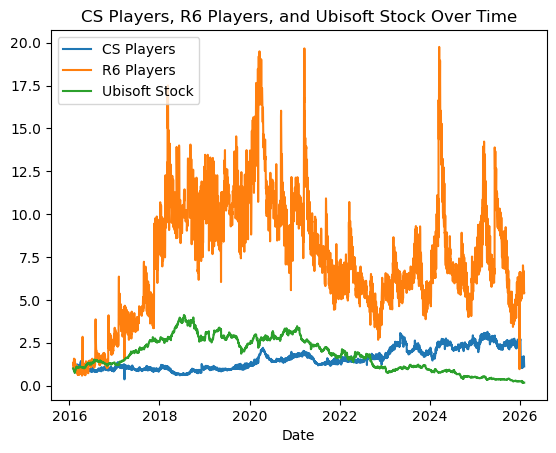

In [203]:
import matplotlib.pyplot as plt

# Drop rows where any are missing (There shouldn't be any but just in case)
plot_df = stat_df[
    ['Players_cs', 'Players_r6', 'Close']
].dropna()

# Normalize so everything starts at 1.0
plot_df_norm = plot_df / plot_df.iloc[0]

plt.figure()
plt.plot(plot_df_norm.index, plot_df_norm['Players_cs'], label='CS Players')
plt.plot(plot_df_norm.index, plot_df_norm['Players_r6'], label='R6 Players')
plt.plot(plot_df_norm.index, plot_df_norm['Close'], label='Ubisoft Stock')

plt.xlabel('Date')
plt.title('CS Players, R6 Players, and Ubisoft Stock Over Time')
plt.legend()
plt.show()


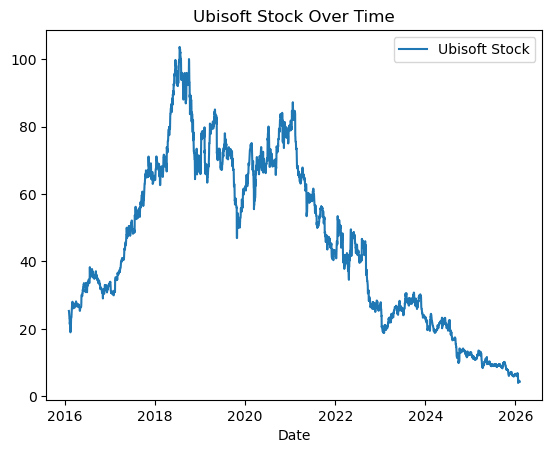

In [204]:
import matplotlib.pyplot as plt

# Normalize so everything starts at 1.0
plot_df_norm = plot_df / plot_df.iloc[0]

plt.figure()
plt.plot(stat_df['Close'], label='Ubisoft Stock')

plt.xlabel('Date')
plt.title('Ubisoft Stock Over Time')
plt.legend()
plt.show()


In [119]:
# Player data day of can't be used, because if we buy at close price player data includes players throughout the day
# We don't need to do this with stock data, because for now we're saying we will buy at close price, so we will know what it is

player_cols = [
    'Players_cs',
    'cs_7d_mean',
    'cs_30d_mean',
    'cs_momentum',
    'cs_volatility_30d',
    'cs_players_lag1',
    'cs_players_lag2',
    'cs_log',

    'Players_r6',
    'r6_7d_mean',
    'r6_30d_mean',
    'r6_momentum',
    'r6_volatility_30d',
    'r6_players_lag1',
    'r6_players_lag2',
    'r6_log',
]

stat_df[player_cols] = stat_df[player_cols].shift(1)

In [123]:
# Target. Horizon should be set based on how long we plan to hold the stock. Using 1 for now
horizon = 1

stat_df['future_return'] = (
    stat_df['Close'].shift(-horizon) / stat_df['Close'] - 1
)

stat_df['target_up'] = (stat_df['future_return'] > 0).astype(int)


In [122]:
stat_df.columns

Index(['Players_cs', 'Players_r6', 'cs_7d_mean', 'cs_7d_std', 'cs_30d_mean',
       'cs_30d_std', 'cs_vs_30d', 'cs_momentum', 'cs_volatility_30d',
       'r6_7d_mean', 'r6_7d_std', 'r6_30d_mean', 'r6_30d_std', 'r6_vs_30d',
       'r6_momentum', 'r6_volatility_30d', 'dow', 'month', 'week_of_year',
       'cs_log', 'r6_log', 'cs_players_lag1', 'r6_players_lag1',
       'cs_players_lag2', 'r6_players_lag2', 'Close', 'stock_ret_1d',
       'stock_ret_5d', 'stock_ret_lag1', 'stock_ret_lag2', 'stock_ma_5',
       'stock_ma_30', 'stock_momentum', 'stock_vol_30d', 'future_return',
       'target_up'],
      dtype='object')

In [124]:
features = [
    # Player data features

    'cs_players_lag1',
    'cs_players_lag2',
    'r6_players_lag1',
    'r6_players_lag2',
    'cs_7d_mean',
    'cs_30d_mean',
    'cs_momentum',
    'cs_volatility_30d',
    'r6_7d_mean',
    'r6_30d_mean',
    'r6_momentum',
    'r6_volatility_30d',

    # Stock features
    'stock_ret_1d',
    'stock_ret_5d',
    'stock_ret_lag1',
    'stock_ret_lag2',
    'stock_ma_5',
    'stock_ma_30',
    'stock_momentum',
    'stock_vol_30d',

    # Date/Time features | model was too reliant on these
    #'dow',
    #'month',
    #'week_of_year'
]


In [138]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import pandas as pd

model_df = stat_df[features + ['target_up']].dropna()

n = len(model_df)
train_end = int(n * 3/5)
val_end   = int(n * 4/5)

X_train_val = model_df.iloc[:train_end][features]
y_train_val = model_df.iloc[:train_end]['target_up']

X_final_test = model_df.iloc[train_end:val_end][features]
y_final_test = model_df.iloc[train_end:val_end]['target_up']

print(f"Train+Val size: {X_train_val.shape[0]}, Final Test size: {X_final_test.shape[0]}")

tscv = TimeSeriesSplit(n_splits=5)

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    max_depth=2,  
    min_child_weight=10, 
    gamma=1.0,   
)

param_grid = {
    'n_estimators': [150, 200],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.6, 0.7]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_val, y_train_val)

best_model = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

train_probs = best_model.predict_proba(X_train_val)[:, 1]
print("Train+Val ROC AUC:", roc_auc_score(y_train_val, train_probs))

final_probs = best_model.predict_proba(X_final_test)[:, 1]

threshold = 0.4
final_preds = (final_probs > threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_final_test, final_preds).ravel()

pos_precision = tp / (tp + fp) if (tp + fp) > 0 else float('nan')
neg_precision = tn / (tn + fn) if (tn + fn) > 0 else float('nan')
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("\nRESULTS")
print("---------------------")
print("Positive predictions:", final_preds.sum())
print("Negative predictions:", len(final_preds) - final_preds.sum())
print("Positive prediction accuracy (TP / predicted positives):", pos_precision)
print("Negative prediction accuracy (TN / predicted negatives):", neg_precision)
print("Overall accuracy:", accuracy)
print("FINAL TEST ROC AUC:", roc_auc_score(y_final_test, final_probs))


Train+Val size: 2193, Final Test size: 731
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'n_estimators': 150, 'subsample': 0.7}
Train+Val ROC AUC: 0.7294694046231565

FINAL HOLDOUT RESULTS
---------------------
Positive predictions: 238
Negative predictions: 493
Positive prediction accuracy (TP / predicted positives): 0.36554621848739494
Negative prediction accuracy (TN / predicted negatives): 0.6855983772819473
Overall accuracy: 0.5813953488372093
FINAL TEST ROC AUC: 0.5243877706231304


In [139]:
importance = best_model.feature_importances_

feat_imp = pd.Series(
    importance,
    index=features
).sort_values(ascending=False)

print(feat_imp)


cs_players_lag2      0.068838
cs_7d_mean           0.066299
cs_players_lag1      0.057245
cs_30d_mean          0.055953
r6_7d_mean           0.055346
r6_players_lag1      0.051636
stock_ret_lag2       0.051079
r6_players_lag2      0.049539
stock_ma_30          0.048706
stock_ma_5           0.047988
r6_volatility_30d    0.047853
r6_momentum          0.047371
stock_momentum       0.046275
stock_ret_1d         0.045955
stock_ret_5d         0.045304
cs_volatility_30d    0.044310
cs_momentum          0.043788
stock_vol_30d        0.043637
r6_30d_mean          0.043356
stock_ret_lag1       0.039518
dtype: float32


In [140]:
groups = {
    "CS engagement": [
        "cs_players_lag1", "cs_players_lag2", "cs_7d_mean",
        "cs_30d_mean", "cs_momentum", "cs_volatility_30d"
    ],
    "R6 engagement": [
        "r6_players_lag1", "r6_players_lag2", "r6_7d_mean",
        "r6_30d_mean", "r6_momentum", "r6_volatility_30d"
    ],
    "Stock dynamics": [
        "stock_ret_1d", "stock_ret_lag1", "stock_ret_lag2",
        "stock_ret_5d", "stock_ma_5", "stock_ma_30",
        "stock_momentum", "stock_vol_30d"
    ]
}

for g, cols in groups.items():
    print(g, feat_imp[feat_imp.index.isin(cols)].sum())

CS engagement 0.33643344
R6 engagement 0.29510227
Stock dynamics 0.36846435


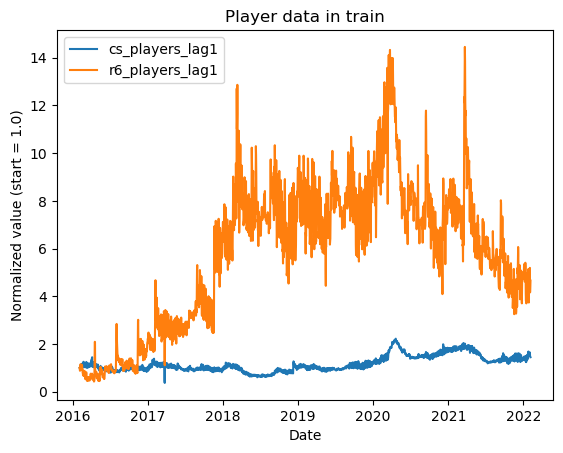

In [141]:
import matplotlib.pyplot as plt

# Drop rows where any are missing (There shouldn't be any but just in case)
plot_df = X_train_val[
    ['cs_players_lag1', 'r6_players_lag1']
].dropna()

# Normalize so everything starts at 1.0
plot_df_norm = plot_df / plot_df.iloc[0]

plt.figure()
plt.plot(plot_df_norm.index, plot_df_norm['cs_players_lag1'], label='cs_players_lag1')
plt.plot(plot_df_norm.index, plot_df_norm['r6_players_lag1'], label='r6_players_lag1')

plt.xlabel('Date')
plt.ylabel('Normalized value (start = 1.0)')
plt.title('Player data in train')
plt.legend()
plt.show()


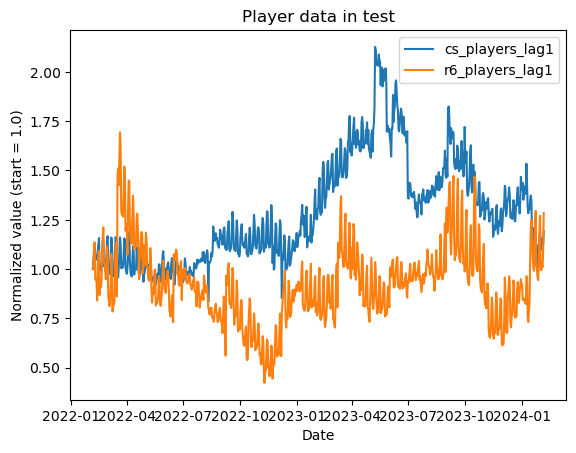

In [142]:
import matplotlib.pyplot as plt

# Drop rows where any are missing (There shouldn't be any but just in case)
plot_df = X_final_test[
    ['cs_players_lag1', 'r6_players_lag1']
].dropna()

# Normalize so everything starts at 1.0
plot_df_norm = plot_df / plot_df.iloc[0]

plt.figure()
plt.plot(plot_df_norm.index, plot_df_norm['cs_players_lag1'], label='cs_players_lag1')
plt.plot(plot_df_norm.index, plot_df_norm['r6_players_lag1'], label='r6_players_lag1')

plt.xlabel('Date')
plt.ylabel('Normalized value (start = 1.0)')
plt.title('Player data in test')
plt.legend()
plt.show()


In [149]:
stat_df

,Players_cs,Players_r6,cs_7d_mean,cs_7d_std,cs_30d_mean,cs_30d_std,cs_vs_30d,cs_momentum,cs_volatility_30d,r6_7d_mean,...,stock_ma_5,stock_ma_30,stock_momentum,stock_vol_30d,future_return,target_up,sma_signal,sma_strategy_ret,sma_strategy_cumret,buy_and_hold_cumret
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-02-01,NaN,NaN,NaN,26090.373031,NaN,32958.009575,-0.035137,NaN,NaN,NaN,...,25.446,25.357167,0.088833,0.027522,-0.007896,0,1,-0.000592,0.999408,0.999408
2016-02-02,592950.0,10220.0,613243.714286,25930.492628,614543.233333,32532.032853,-0.038857,-1299.519048,0.053630,11204.000000,...,25.258,25.295500,-0.037500,0.027303,-0.023677,0,0,-0.000000,0.999408,0.991517
2016-02-03,588658.0,13912.0,613385.428571,26717.958479,612456.366667,32703.060570,-0.030121,929.061905,0.053117,11598.571429,...,25.032,25.211833,-0.179834,0.027572,-0.022213,0,0,-0.000000,0.999408,0.968041
2016-02-04,593220.0,12820.0,612247.428571,27603.498031,611643.100000,32990.873904,-0.037864,604.328571,0.053468,11883.142857,...,24.866,25.131167,-0.265167,0.027540,-0.036265,0,0,-0.000000,0.999408,0.946538
2016-02-05,587791.0,12208.0,611237.714286,27389.112501,610922.866667,32975.191756,-0.000415,314.847619,0.054002,12133.857143,...,24.421,25.018667,-0.597667,0.028178,0.000000,0,0,-0.000000,0.999408,0.912212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-01,983392.0,61077.0,861266.571429,112820.173086,920422.933333,249120.864792,0.122179,-59156.361905,0.298348,63407.857143,...,4.445,5.872000,-1.427000,0.084272,0.000000,0,0,-0.000000,18.157425,1.735688
2026-02-02,1013096.0,68239.0,862609.714286,112149.621295,902793.400000,213379.435989,-0.025260,-40183.685714,0.275944,62909.428571,...,4.445,5.872000,-1.427000,0.084272,0.000000,0,0,-0.000000,18.157425,1.611789
2026-02-03,856350.0,64775.0,865923.000000,114715.682859,878542.000000,162582.009035,-0.059319,-12619.000000,0.242879,62017.428571,...,4.445,5.872000,-1.427000,0.084272,0.000000,0,0,-0.000000,18.157425,1.496735


C:\Users\dimwi\AppData\Local\Temp\ipykernel_29952\2748899763.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sma_df['sma_signal'] = (test_sma_df['stock_ma_5'] > test_sma_df['stock_ma_30']).astype(int)
C:\Users\dimwi\AppData\Local\Temp\ipykernel_29952\2748899763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sma_df['sma_strategy_ret'] = test_sma_df['sma_signal'] * test_sma_df['future_return']
C:\Users\dimwi\AppData\Local\Temp\ipykernel_29952\2748899763.py:7: SettingWithCopyWarning: 
A valu

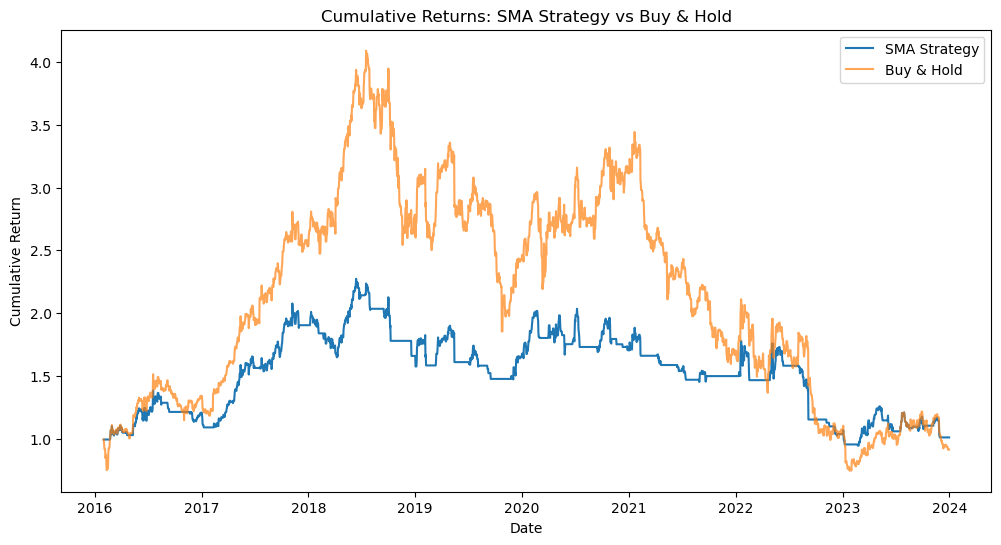

In [209]:
# Test pure SMA (pre 2024 data for testing)
test_sma_df = stat_df[stat_df.index < '2024-01-01']

test_sma_df['sma_signal'] = (test_sma_df['stock_ma_5'] > test_sma_df['stock_ma_30']).astype(int)
test_sma_df['sma_strategy_ret'] = test_sma_df['sma_signal'] * test_sma_df['future_return']

test_sma_df['sma_strategy_cumret'] = (1 + test_sma_df['sma_strategy_ret']).cumprod()
test_sma_df['buy_and_hold_cumret'] = (1 + test_sma_df['future_return']).cumprod()

plt.figure(figsize=(12,6))
plt.plot(test_sma_df.index, test_sma_df['sma_strategy_cumret'], label='SMA Strategy')
plt.plot(test_sma_df.index, test_sma_df['buy_and_hold_cumret'], label='Buy & Hold', alpha=0.7)
plt.title('Cumulative Returns: SMA Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


=== SMA + XGBoost: Earnings & Max Drawdown ===
SMA+XGB Buy>0.5, Sell<0.3:  Earnings =  -0.11% | Max DD =  -1.34%
SMA+XGB Buy>0.4, Sell<0.3:  Earnings = -36.41% | Max DD = -39.33%
SMA+XGB Buy>0.3, Sell<0.3:  Earnings = -39.38% | Max DD = -46.82%
SMA+XGB Buy>0.5, Sell<0.2:  Earnings =  -0.11% | Max DD =  -1.34%
SMA+XGB Buy>0.4, Sell<0.2:  Earnings = -37.74% | Max DD = -40.60%
SMA+XGB Buy>0.3, Sell<0.2:  Earnings = -41.19% | Max DD = -46.36%
SMA+XGB Buy>0.5, Sell<0.1:  Earnings =  -0.11% | Max DD =  -1.34%
SMA+XGB Buy>0.4, Sell<0.1:  Earnings = -37.74% | Max DD = -40.60%
SMA+XGB Buy>0.3, Sell<0.1:  Earnings = -41.19% | Max DD = -46.36%
SMA+XGB Buy>0, Sell<0.3:  Earnings = -41.19% | Max DD = -46.36%
SMA+XGB Buy>0, Sell<0.2:  Earnings = -41.19% | Max DD = -46.36%
SMA+XGB Buy>0, Sell<0.1:  Earnings = -41.19% | Max DD = -46.36%
SMA+XGB Buy>0.5, Sell<0:  Earnings =  -0.11% | Max DD =  -1.34%
SMA+XGB Buy>0.4, Sell<0:  Earnings = -37.74% | Max DD = -40.60%
SMA+XGB Buy>0.3, Sell<0:  Earnings = -

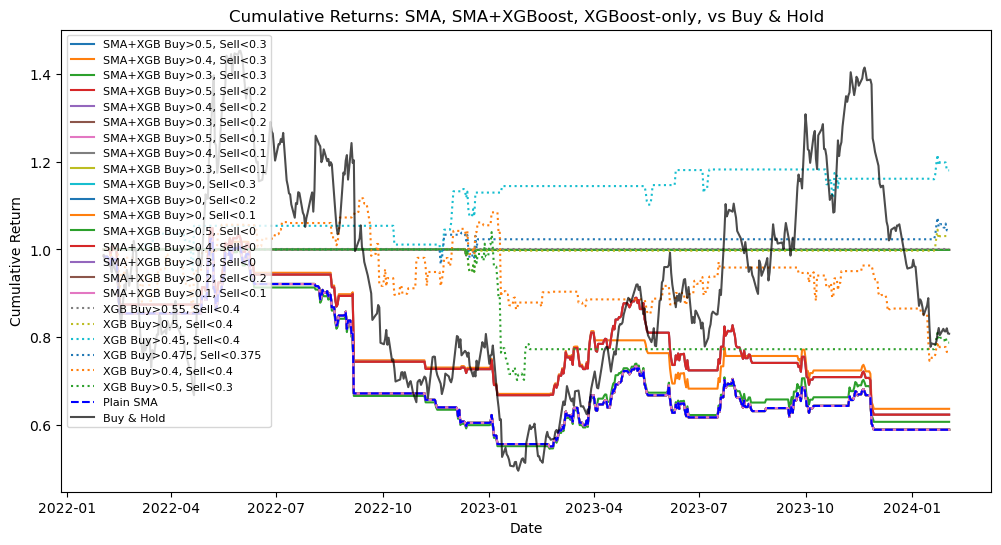

In [224]:
import numpy as np
import matplotlib.pyplot as plt

# Train on first 3/5 of data, test on next 1/5. Last 1/5 is to test at the end once thresholds are finalized

# Lot of repeated code between cells, just copy-pasting for ease

train_end = int(len(model_df) * 3/5)
val_end   = int(len(model_df) * 4/5)

test_idx = stat_df.index[train_end:val_end]
test_df = stat_df.loc[test_idx].copy()

test_df['sma_signal'] = (test_df['stock_ma_5'] > test_df['stock_ma_30']).astype(int)

test_df['sma_ret'] = test_df['sma_signal'] * test_df['future_return']
test_df['cum_sma_ret'] = (1 + test_df['sma_ret']).cumprod()

X_test = test_df[features]
test_df['xgb_score'] = best_model.predict_proba(X_test)[:, 1]


def max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdown = cum_returns / running_max - 1.0
    return drawdown.min()

# Get percent earnings
def percent_earnings(cum_returns):
    return cum_returns.iloc[-1] - 1.0

# -------------------------
# Performs a combined SMA + XGBoost strategy where both signals must agree to buy and only one is required to sell
# Tried with other variations but they are all equally bad
# -------------------------

def combined_sma_xgb_strategy(df, buy_threshold=0.5, sell_threshold=0.4):
    position = 0
    returns = []

    for idx, row in df.iterrows():
        if row['sma_signal'] == 1 and row['xgb_score'] > buy_threshold:
            position = 1
        elif position == 1 and (row['sma_signal'] == 0 or row['xgb_score'] < sell_threshold):
            position = 0
        returns.append(position * row['future_return'])

    df['strategy_ret'] = returns
    df['cum_strategy_ret'] = (1 + df['strategy_ret']).cumprod()
    df['cum_buy_and_hold'] = (1 + df['future_return']).cumprod()
    return df

# -------------------------
# Performs a pure XGBoost strategy where buying and selling is based solely on XGBoost scores
# -------------------------

def pure_xgb_strategy(df, buy_threshold=0.55, sell_threshold=0.45):
    position = 0
    returns = []

    for idx, row in df.iterrows():
        if row['xgb_score'] > buy_threshold:
            position = 1
        elif row['xgb_score'] < sell_threshold:
            position = 0
        returns.append(position * row['future_return'])

    df['xgb_strategy_ret'] = returns
    df['cum_xgb_strategy'] = (1 + df['xgb_strategy_ret']).cumprod()
    return df

# Thresholds for combined
thresholds1 = [
    (0.5, 0.3), (0.4, 0.3), (0.3, 0.3),
    (0.5, 0.2), (0.4, 0.2), (0.3, 0.2),
    (0.5, 0.1), (0.4, 0.1), (0.3, 0.1),
    (0, 0.3), (0, 0.2), (0, 0.1),
    (0.5, 0), (0.4, 0), (0.3, 0),
    (0.2, 0.2), (0.1, 0.1),
]

# Thresholds for pure XGBoost
thresholds2 = [
    (0.55, 0.4),
    (0.5, 0.4),
    (0.45, 0.4),
    (0.475, 0.375),
    (0.4, 0.4),
    (0.5, 0.3)
]


# Print returns and drawdowns for all strategies
print("\n=== SMA + XGBoost: Earnings & Max Drawdown ===")
for buy_t, sell_t in thresholds1:
    df_out = combined_sma_xgb_strategy(test_df.copy(), buy_threshold=buy_t, sell_threshold=sell_t)
    earn = percent_earnings(df_out['cum_strategy_ret'])
    mdd  = max_drawdown(df_out['cum_strategy_ret'])
    print(
        f"SMA+XGB Buy>{buy_t}, Sell<{sell_t}:  "
        f"Earnings = {earn:>7.2%} | Max DD = {mdd:>7.2%}"
    )

print("\n=== Pure XGBoost: Earnings & Max Drawdown ===")
for buy_t, sell_t in thresholds2:
    df_xgb = pure_xgb_strategy(test_df.copy(), buy_threshold=buy_t, sell_threshold=sell_t)
    earn = percent_earnings(df_xgb['cum_xgb_strategy'])
    mdd  = max_drawdown(df_xgb['cum_xgb_strategy'])
    print(
        f"XGB Buy>{buy_t}, Sell<{sell_t}:      "
        f"Earnings = {earn:>7.2%} | Max DD = {mdd:>7.2%}"
    )

print("\n=== Benchmarks ===")
sma_earn = percent_earnings(test_df['cum_sma_ret'])
sma_mdd  = max_drawdown(test_df['cum_sma_ret'])

bh_cum  = (1 + test_df['future_return']).cumprod()
bh_earn = percent_earnings(bh_cum)
bh_mdd  = max_drawdown(bh_cum)

print(f"Plain SMA:    Earnings = {sma_earn:>7.2%} | Max DD = {sma_mdd:>7.2%}")
print(f"Buy & Hold:  Earnings = {bh_earn:>7.2%} | Max DD = {bh_mdd:>7.2%}")

# Plot combined
plt.figure(figsize=(12,6))

for buy_t, sell_t in thresholds1:
    df_out = combined_sma_xgb_strategy(test_df.copy(), buy_threshold=buy_t, sell_threshold=sell_t)
    plt.plot(df_out.index, df_out['cum_strategy_ret'],
             label=f'SMA+XGB Buy>{buy_t}, Sell<{sell_t}')

# Plot pure XGBoost
for buy_t, sell_t in thresholds2:
    df_xgb = pure_xgb_strategy(test_df.copy(), buy_threshold=buy_t, sell_threshold=sell_t)
    plt.plot(df_xgb.index, df_xgb['cum_xgb_strategy'],
             linestyle=':', label=f'XGB Buy>{buy_t}, Sell<{sell_t}')

# Plot SMA
plt.plot(test_df.index, test_df['cum_sma_ret'],
         label='Plain SMA', color='blue', linestyle='--')

# Plot stock
plt.plot(test_df.index, (1 + test_df['stock_ret_1d']).cumprod(),
         label='Buy & Hold', color='black', alpha=0.7)

plt.title('Cumulative Returns: SMA, SMA+XGBoost, XGBoost-only, vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left', fontsize=8)
plt.show()





=== SMA + XGBoost: Earnings & Max Drawdown ===
SMA+XGB Buy>0.5, Sell<0.3:  Earnings =  52.34% | Max DD =  -5.17%
SMA+XGB Buy>0.4, Sell<0.3:  Earnings = 178.02% | Max DD = -39.33%
SMA+XGB Buy>0.3, Sell<0.3:  Earnings = 144.06% | Max DD = -46.82%
SMA+XGB Buy>0.5, Sell<0.2:  Earnings =  45.26% | Max DD = -13.24%
SMA+XGB Buy>0.4, Sell<0.2:  Earnings =  36.45% | Max DD = -44.29%
SMA+XGB Buy>0.3, Sell<0.2:  Earnings =   3.93% | Max DD = -57.27%
SMA+XGB Buy>0.5, Sell<0.1:  Earnings =  45.26% | Max DD = -13.24%
SMA+XGB Buy>0.4, Sell<0.1:  Earnings =  36.45% | Max DD = -44.29%
SMA+XGB Buy>0.3, Sell<0.1:  Earnings =   3.93% | Max DD = -57.27%
SMA+XGB Buy>0, Sell<0.3:  Earnings =   0.90% | Max DD = -58.52%
SMA+XGB Buy>0, Sell<0.2:  Earnings =   0.90% | Max DD = -58.52%
SMA+XGB Buy>0, Sell<0.1:  Earnings =   0.90% | Max DD = -58.52%
SMA+XGB Buy>0.5, Sell<0:  Earnings =  45.26% | Max DD = -13.24%
SMA+XGB Buy>0.4, Sell<0:  Earnings =  36.45% | Max DD = -44.29%
SMA+XGB Buy>0.3, Sell<0:  Earnings =  

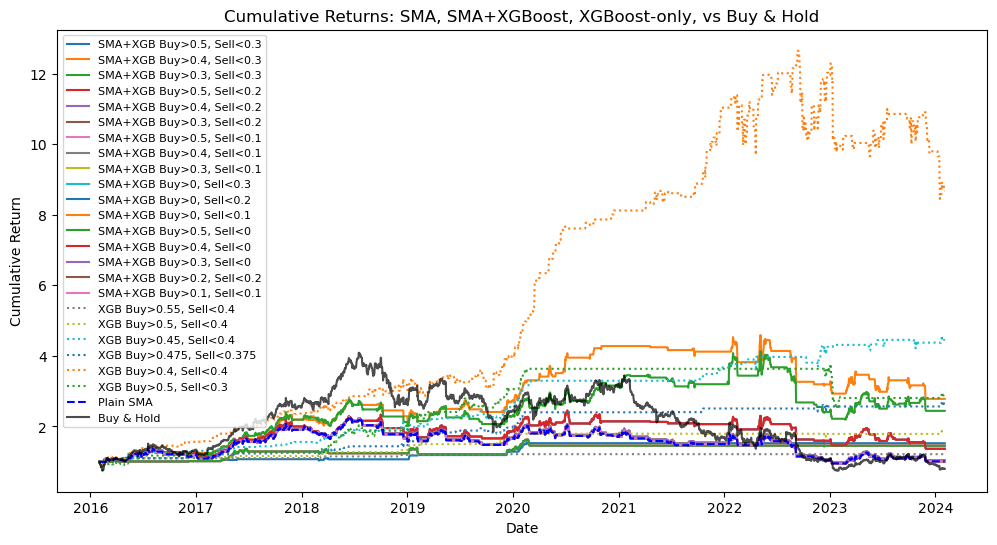

In [223]:
import numpy as np
import matplotlib.pyplot as plt

# Train on first 3/5 of data, test on next 1/5. Last 1/5 is to test at the end once thresholds are finalized

# Lot of repeated code between cells, just copy-pasting for ease

train_end = int(len(model_df) * 3/5)
val_end   = int(len(model_df) * 4/5)

#This time, we're using the training data too to see what it would look like, keeping in mind model was trained on it

test_idx = stat_df.index[:val_end]
test_df = stat_df.loc[test_idx].copy()

test_df['sma_signal'] = (test_df['stock_ma_5'] > test_df['stock_ma_30']).astype(int)

test_df['sma_ret'] = test_df['sma_signal'] * test_df['future_return']
test_df['cum_sma_ret'] = (1 + test_df['sma_ret']).cumprod()

X_test = test_df[features]
test_df['xgb_score'] = best_model.predict_proba(X_test)[:, 1]


def max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdown = cum_returns / running_max - 1.0
    return drawdown.min()

# Get percent earnings
def percent_earnings(cum_returns):
    return cum_returns.iloc[-1] - 1.0

# -------------------------
# Performs a combined SMA + XGBoost strategy where both signals must agree to buy and only one is required to sell
# Tried with other variations but they are all equally bad
# -------------------------

def combined_sma_xgb_strategy(df, buy_threshold=0.5, sell_threshold=0.4):
    position = 0
    returns = []

    for idx, row in df.iterrows():
        if row['sma_signal'] == 1 and row['xgb_score'] > buy_threshold:
            position = 1
        elif position == 1 and (row['sma_signal'] == 0 or row['xgb_score'] < sell_threshold):
            position = 0
        returns.append(position * row['future_return'])

    df['strategy_ret'] = returns
    df['cum_strategy_ret'] = (1 + df['strategy_ret']).cumprod()
    df['cum_buy_and_hold'] = (1 + df['future_return']).cumprod()
    return df

# -------------------------
# Performs a pure XGBoost strategy where buying and selling is based solely on XGBoost scores
# -------------------------

def pure_xgb_strategy(df, buy_threshold=0.55, sell_threshold=0.45):
    position = 0
    returns = []

    for idx, row in df.iterrows():
        if row['xgb_score'] > buy_threshold:
            position = 1
        elif row['xgb_score'] < sell_threshold:
            position = 0
        returns.append(position * row['future_return'])

    df['xgb_strategy_ret'] = returns
    df['cum_xgb_strategy'] = (1 + df['xgb_strategy_ret']).cumprod()
    return df

# Thresholds for combined
thresholds1 = [
    (0.5, 0.3), (0.4, 0.3), (0.3, 0.3),
    (0.5, 0.2), (0.4, 0.2), (0.3, 0.2),
    (0.5, 0.1), (0.4, 0.1), (0.3, 0.1),
    (0, 0.3), (0, 0.2), (0, 0.1),
    (0.5, 0), (0.4, 0), (0.3, 0),
    (0.2, 0.2), (0.1, 0.1),
]

# Thresholds for pure XGBoost
thresholds2 = [
    (0.55, 0.4),
    (0.5, 0.4),
    (0.45, 0.4),
    (0.475, 0.375),
    (0.4, 0.4),
    (0.5, 0.3)
]


# Print returns and drawdowns for all strategies
print("\n=== SMA + XGBoost: Earnings & Max Drawdown ===")
for buy_t, sell_t in thresholds1:
    df_out = combined_sma_xgb_strategy(test_df.copy(), buy_threshold=buy_t, sell_threshold=sell_t)
    earn = percent_earnings(df_out['cum_strategy_ret'])
    mdd  = max_drawdown(df_out['cum_strategy_ret'])
    print(
        f"SMA+XGB Buy>{buy_t}, Sell<{sell_t}:  "
        f"Earnings = {earn:>7.2%} | Max DD = {mdd:>7.2%}"
    )

print("\n=== Pure XGBoost: Earnings & Max Drawdown ===")
for buy_t, sell_t in thresholds2:
    df_xgb = pure_xgb_strategy(test_df.copy(), buy_threshold=buy_t, sell_threshold=sell_t)
    earn = percent_earnings(df_xgb['cum_xgb_strategy'])
    mdd  = max_drawdown(df_xgb['cum_xgb_strategy'])
    print(
        f"XGB Buy>{buy_t}, Sell<{sell_t}:      "
        f"Earnings = {earn:>7.2%} | Max DD = {mdd:>7.2%}"
    )

print("\n=== Benchmarks ===")
sma_earn = percent_earnings(test_df['cum_sma_ret'])
sma_mdd  = max_drawdown(test_df['cum_sma_ret'])

bh_cum  = (1 + test_df['future_return']).cumprod()
bh_earn = percent_earnings(bh_cum)
bh_mdd  = max_drawdown(bh_cum)

print(f"Plain SMA:    Earnings = {sma_earn:>7.2%} | Max DD = {sma_mdd:>7.2%}")
print(f"Buy & Hold:  Earnings = {bh_earn:>7.2%} | Max DD = {bh_mdd:>7.2%}")

# Plot combined
plt.figure(figsize=(12,6))

for buy_t, sell_t in thresholds1:
    df_out = combined_sma_xgb_strategy(test_df.copy(), buy_threshold=buy_t, sell_threshold=sell_t)
    plt.plot(df_out.index, df_out['cum_strategy_ret'],
             label=f'SMA+XGB Buy>{buy_t}, Sell<{sell_t}')

# Plot pure XGBoost
for buy_t, sell_t in thresholds2:
    df_xgb = pure_xgb_strategy(test_df.copy(), buy_threshold=buy_t, sell_threshold=sell_t)
    plt.plot(df_xgb.index, df_xgb['cum_xgb_strategy'],
             linestyle=':', label=f'XGB Buy>{buy_t}, Sell<{sell_t}')

# Plot SMA
plt.plot(test_df.index, test_df['cum_sma_ret'],
         label='Plain SMA', color='blue', linestyle='--')

# Plot stock
plt.plot(test_df.index, (1 + test_df['future_return']).cumprod(),
         label='Buy & Hold', color='black', alpha=0.7)

plt.title('Cumulative Returns: SMA, SMA+XGBoost, XGBoost-only, vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left', fontsize=8)
plt.show()





=== SMA + XGBoost: Earnings & Max Drawdown ===

=== Pure XGBoost: Earnings & Max Drawdown ===
XGB Buy>0.45, Sell<0.4:      Earnings = -56.29% | Max DD = -58.95%

=== Benchmarks ===
Plain SMA:    Earnings = -70.90% | Max DD = -71.97%
Buy & Hold:  Earnings = -78.36% | Max DD = -83.70%


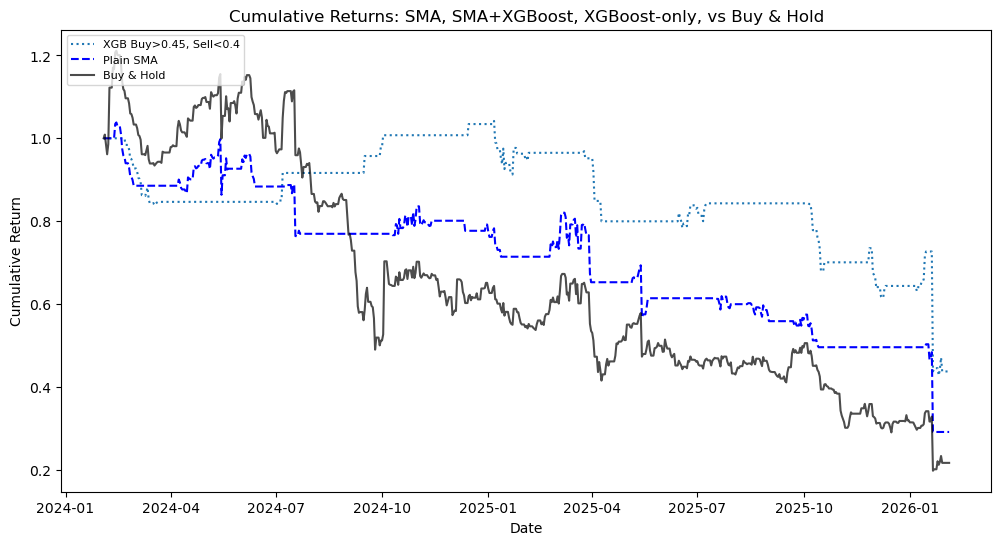

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Train on first 3/5 of data, test on next 1/5. Last 1/5 is to test at the end once thresholds are finalized

# Lot of repeated code between cells, just copy-pasting for ease

train_end = int(len(model_df) * 3/5)
val_end   = int(len(model_df) * 4/5)

# Now, we're actually running the test

test_idx = stat_df.index[val_end:len(stat_df)-1]
test_df = stat_df.loc[test_idx].copy()

test_df['sma_signal'] = (test_df['stock_ma_5'] > test_df['stock_ma_30']).astype(int)

test_df['sma_ret'] = test_df['sma_signal'] * test_df['future_return']
test_df['cum_sma_ret'] = (1 + test_df['sma_ret']).cumprod()

X_test = test_df[features]
test_df['xgb_score'] = best_model.predict_proba(X_test)[:, 1]


def max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdown = cum_returns / running_max - 1.0
    return drawdown.min()

# Get percent earnings
def percent_earnings(cum_returns):
    return cum_returns.iloc[-1] - 1.0

# -------------------------
# Performs a combined SMA + XGBoost strategy where both signals must agree to buy and only one is required to sell
# Tried with other variations but they are all equally bad
# -------------------------

def combined_sma_xgb_strategy(df, buy_threshold=0.5, sell_threshold=0.4):
    position = 0
    returns = []

    for idx, row in df.iterrows():
        if row['sma_signal'] == 1 and row['xgb_score'] > buy_threshold:
            position = 1
        elif position == 1 and (row['sma_signal'] == 0 or row['xgb_score'] < sell_threshold):
            position = 0
        returns.append(position * row['future_return'])

    df['strategy_ret'] = returns
    df['cum_strategy_ret'] = (1 + df['strategy_ret']).cumprod()
    df['cum_buy_and_hold'] = (1 + df['future_return']).cumprod()
    return df

# -------------------------
# Performs a pure XGBoost strategy where buying and selling is based solely on XGBoost scores
# -------------------------

def pure_xgb_strategy(df, buy_threshold=0.55, sell_threshold=0.45):
    position = 0
    returns = []

    for idx, row in df.iterrows():
        if row['xgb_score'] > buy_threshold:
            position = 1
        elif row['xgb_score'] < sell_threshold:
            position = 0
        returns.append(position * row['future_return'])

    df['xgb_strategy_ret'] = returns
    df['cum_xgb_strategy'] = (1 + df['xgb_strategy_ret']).cumprod()
    return df

# Thresholds for combined
thresholds1 = [
    (0, 0.1) # XGBoost is only being used as an extra sell indicator
]

# Thresholds for pure XGBoost
thresholds2 = [
    (0.4, 0.4), # Just to see
    (0.45, 0.4), # Real candidate overall < This is the one we're looking at, and this was decided based off testing previously BEFORE seeing results here
]


# Print returns and drawdowns for all strategies
print("\n=== SMA + XGBoost: Earnings & Max Drawdown ===")
for buy_t, sell_t in thresholds1:
    df_out = combined_sma_xgb_strategy(test_df.copy(), buy_threshold=buy_t, sell_threshold=sell_t)
    earn = percent_earnings(df_out['cum_strategy_ret'])
    mdd  = max_drawdown(df_out['cum_strategy_ret'])
    print(
        f"SMA+XGB Buy>{buy_t}, Sell<{sell_t}:  "
        f"Earnings = {earn:>7.2%} | Max DD = {mdd:>7.2%}"
    )

print("\n=== Pure XGBoost: Earnings & Max Drawdown ===")
for buy_t, sell_t in thresholds2:
    df_xgb = pure_xgb_strategy(test_df.copy(), buy_threshold=buy_t, sell_threshold=sell_t)
    earn = percent_earnings(df_xgb['cum_xgb_strategy'])
    mdd  = max_drawdown(df_xgb['cum_xgb_strategy'])
    print(
        f"XGB Buy>{buy_t}, Sell<{sell_t}:      "
        f"Earnings = {earn:>7.2%} | Max DD = {mdd:>7.2%}"
    )

print("\n=== Benchmarks ===")
sma_earn = percent_earnings(test_df['cum_sma_ret'])
sma_mdd  = max_drawdown(test_df['cum_sma_ret'])

bh_cum  = (1 + test_df['future_return']).cumprod()
bh_earn = percent_earnings(bh_cum)
bh_mdd  = max_drawdown(bh_cum)

print(f"Plain SMA:    Earnings = {sma_earn:>7.2%} | Max DD = {sma_mdd:>7.2%}")
print(f"Buy & Hold:  Earnings = {bh_earn:>7.2%} | Max DD = {bh_mdd:>7.2%}")

# Plot combined
plt.figure(figsize=(12,6))

for buy_t, sell_t in thresholds1:
    df_out = combined_sma_xgb_strategy(test_df.copy(), buy_threshold=buy_t, sell_threshold=sell_t)
    plt.plot(df_out.index, df_out['cum_strategy_ret'],
             label=f'SMA+XGB Buy>{buy_t}, Sell<{sell_t}')

# Plot pure XGBoost
for buy_t, sell_t in thresholds2:
    df_xgb = pure_xgb_strategy(test_df.copy(), buy_threshold=buy_t, sell_threshold=sell_t)
    plt.plot(df_xgb.index, df_xgb['cum_xgb_strategy'],
             linestyle=':', label=f'XGB Buy>{buy_t}, Sell<{sell_t}')

# Plot SMA
plt.plot(test_df.index, test_df['cum_sma_ret'],
         label='Plain SMA', color='blue', linestyle='--')

# Plot stock
plt.plot(test_df.index, (1 + test_df['future_return']).cumprod(),
         label='Buy & Hold', color='black', alpha=0.7)

plt.title('Cumulative Returns: SMA, SMA+XGBoost, XGBoost-only, vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left', fontsize=8)
plt.show()


